In [2]:
# This code is based on Kayo Yin implementation that can be found at https://github.com/kayoyin/DirtyDocuments
# To properly use GPU processors, export the following env:
# export LD_LIBRARY_PATH=/usr/local/cuda-9.0/lib64:$LD_LIBRARY_PATH
# export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH

from __future__ import print_function, division
import scipy
import scipy.misc

from keras.datasets import mnist
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.metrics import mean_squared_error
import datetime
import sys
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
from keras.models import load_model
import tensorflow as tf
import csv

%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 20, 5

import wandb

import gc

# wandb.init(project="cycle_gan")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K


class InstanceNormalization(Layer):
    """Instance normalization layer.

    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.

    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.

    # Output shape
        Same shape as input.

    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Resources:
* [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
* [Keras Implementation of CycleGAN](https://github.com/eriklindernoren/Keras-GAN/tree/master/cyclegan)
* [Understanding and Implementing CycleGAN in TensorFlow](https://hardikbansal.github.io/CycleGANBlog/)
* [Image-to-image translation with Conditional Adversial Nets](https://phillipi.github.io/pix2pix/)
* [Conditional GAN](https://arxiv.org/pdf/1411.1784.pdf)

## Data sources:
### Dirty documents
* [Digitized Materials from the Rare Book & Special Collections Division](https://www.loc.gov/rr/rarebook/digitalcoll.html)

### Clean documents
* Anywhere online


In [5]:
class DataLoader():
    def __init__(self, img_res=(768, 512)):
        self.img_res = img_res
        self.img_height = img_res[0]
        self.img_width = img_res[1]
        self.loaded_batches = 0
        self.path_A = []
        self.path_B = []
        
    def reset(self):
        self.loaded_batches = 0
        self.path_A = []
        self.path_B = []

    def load_data(self, domain, batch_size=1, is_testing=False, is_random = True):
        path = glob('../%s/*' % domain)
        
        path_size = len(path)
        train_size = round(path_size * 0.065) - 1
        test_size = round(path_size * 0.0125) + 1
        path = path[:train_size] if not is_testing else path[train_size: train_size + test_size]
        
        if is_random: batch_images = np.random.choice(path, size=batch_size)
        else: batch_images = path
        
        imgs = []
        for img_path in batch_images:
            img = image.load_img(img_path, color_mode='grayscale', target_size=(self.img_height, self.img_width))
            img = image.img_to_array(img).astype('float32')
            img = img / 255.0
            if not is_testing and is_random:

                if np.random.random() > 0.5:
                    img = np.fliplr(img)

              
            imgs.append(img)

        imgs = np.array(imgs)

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_typeA = "is_ocr_images"
        data_typeB = "crappy_images"
        path_A = glob('../%s/*' % data_typeA)
        path_B = glob('../%s/*' % data_typeB)
        
        path_size = len(path_A)

        train_size = round(path_size * 0.065) - 1
        test_size = round(path_size * 0.0125) + 1
        
        path_A = path_A[:train_size] if not is_testing else path_A[train_size: train_size + test_size]
        path_B = path_B[:train_size] if not is_testing else path_B[train_size: train_size + test_size]

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                try:
                    img_A = image.load_img(img_A, color_mode='grayscale', target_size=(self.img_height, self.img_width))
                    img_A = image.img_to_array(img_A).astype('float32')
                    img_A = img_A / 255.0

                    img_B = image.load_img(img_B, color_mode='grayscale', target_size=(self.img_height, self.img_width))
                    img_B = image.img_to_array(img_B).astype('float32')
                    img_B = img_B / 255.0

                    if not is_testing and np.random.random() > 0.5:
                            img_A = np.fliplr(img_A)
                            img_B = np.fliplr(img_B)

                    imgs_A.append(img_A)
                    imgs_B.append(img_B)
                except Exception as e:
                    print()

            imgs_A = np.array(imgs_A)
            imgs_B = np.array(imgs_B)

            yield imgs_A, imgs_B
            
    def load_path_split(self, batch_size=1, is_testing=False):
        data_typeA = "is_ocr_images"
        data_typeB = "crappy_images"
        path_A = glob('../%s/*' % data_typeA)
        path_B = glob('../%s/*' % data_typeB)
        
        path_size = len(path_A)

        train_size = round(path_size * 0.065) - 1
        test_size = round(path_size * 0.0125) + 1
        
        path_A = path_A[:train_size] if not is_testing else path_A[train_size: train_size + test_size]
        path_B = path_B[:train_size] if not is_testing else path_B[train_size: train_size + test_size]

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)
        
        self.path_A = path_A
        self.path_B = path_B
        self.is_testing = is_testing

        return self.n_batches
        
    def load_batch_images(self, batch_size=1):
        imgs_A, imgs_B = [], []
        i = self.loaded_batches
        self.loaded_batches += 1
        batch_A = self.path_A[i*batch_size:(i+1)*batch_size]
        batch_B = self.path_B[i*batch_size:(i+1)*batch_size]
        for img_A, img_B in zip(batch_A, batch_B):
            try:
                img_A = image.load_img(img_A, color_mode='grayscale', target_size=(self.img_height, self.img_width))
                img_A = image.img_to_array(img_A).astype('float32')
                img_A = img_A / 255.0

                img_B = image.load_img(img_B, color_mode='grayscale', target_size=(self.img_height, self.img_width))
                img_B = image.img_to_array(img_B).astype('float32')
                img_B = img_B / 255.0

                if not self.is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
                
            except Exception as e:
                print(e)

        imgs_A = np.array(imgs_A)
        imgs_B = np.array(imgs_B)

        return imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img.resize(self.img_res)
        img = img/255.0
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return cv2.imread(path).astype(np.float)


In [6]:
class CycleGAN():
    def __init__(self, d_A=None, d_B=None, g_AB=None, g_BA=None):
        # Input shape
        self.img_rows = 768
        self.img_cols = 512
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.data_loader = DataLoader(img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch1 = int(self.img_rows / 2**4)
        patch2 = int(self.img_cols / 2**4)
        self.disc_patch = (patch1, patch2, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss (mainly to preserve color consistency)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        if d_A:
            self.d_A = d_A
        else:
            self.d_A = self.build_discriminator()
            self.d_A.compile(
                loss='mse',
                optimizer=optimizer,
                metrics=['accuracy']
            )
            
        if d_B:
            self.d_B = d_B
        else:
            self.d_B = self.build_discriminator()
            self.d_B.compile(
                loss='mse',
                optimizer=optimizer,
                metrics=['accuracy']
            )

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator() if not g_AB else g_AB
        self.g_BA = self.build_generator() if not g_BA else g_BA

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)
        

        #img_A = img_A.reshape(1,256, 256,1)
        #img_B = img_B.reshape(1,256, 256,1)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)
        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
        
        model = Model(d0, output_img)
        
        model.compile(optimizer="Adam", loss="mse")
        
        print(model.summary())

        return model

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        model = Model(img, validity)
        model.compile(optimizer="Adam", loss="mse")
        
        return model

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        g_losses = []
        d_losses = []
        
        unlinkFile = True

        for epoch in range(epochs):
            self.data_loader.reset()
            batches_range = self.data_loader.load_path_split(batch_size)
#             for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
            for batch_i in range(batches_range):

                imgs_A, imgs_B = self.data_loader.load_batch_images(batch_size)
                print
                try:
                    # ----------------------
                    #  Train Discriminators
                    # ----------------------

                    # Translate images to opposite domain
                    imgs_A = imgs_A.reshape(-1,self.img_rows, self.img_cols,1)
                    imgs_B = imgs_B.reshape(-1,self.img_rows, self.img_cols,1)
                    fake_B = self.g_AB.predict(imgs_A)
                    fake_A = self.g_BA.predict(imgs_B)

                    # Train the discriminators (original images = real / translated = Fake)
                    dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                    dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                    dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                    dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                    # Total disciminator loss
                    d_loss = 0.5 * np.add(dA_loss, dB_loss)


                    # ------------------
                    #  Train Generators
                    # ------------------

                    # Train the generators
                    g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                            [valid, valid,
                                                            imgs_A, imgs_B,
                                                            imgs_A, imgs_B])

                    elapsed_time = datetime.datetime.now() - start_time

                    # Plot the progress
                    if batch_i % sample_interval == 0:
                        n = gc.collect()
                        print("Number of unreachable objects collected by GC:", n)
                        print("Uncollectable garbage:", gc.garbage)
                        print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                            % ( epoch+1, epochs,
                                                                                batch_i+1, self.data_loader.n_batches,
                                                                                d_loss[0], 100*d_loss[1],
                                                                                g_loss[0],
                                                                                np.mean(g_loss[1:3]),
                                                                                np.mean(g_loss[3:5]),
                                                                                np.mean(g_loss[5:6]),
                                                                                elapsed_time))
                    
#                     wandb.log({'epoch': epoch, 'g_loss': g_loss[0], 'd_loss': d_loss[0]})
                    g_losses.append(g_loss[0])
                    d_losses.append(d_loss[0])
                except Exception as e:
                    print(e)

                # If at save interval => save generated image samples
                if (batch_i % 1000 == 0):
                    self.d_A.save('backup_d_A.h5')
                    self.d_B.save('backup_d_B.h5')
                    self.g_AB.save('backup_g_AB.h5')
                    self.g_BA.save('backup_g_BA.h5')
                    if unlinkFile:
                        if os.path.exists('./backup_losses.csv'):
                            os.remove('./backup_losses.csv')
                        unlinkFile = False
                    with open('./backup_losses.csv', 'a+', newline='') as csvfile:
                        spamwriter = csv.writer(csvfile, delimiter=';',
                                                quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        for i in range(len(g_losses)):
                            spamwriter.writerow([d_losses[i], g_losses[i]])
                    self.sample_images(epoch, batch_i)
                    g_losses = []
                    d_losses = []
                    
        if len(d_losses) > 0:
            with open('./backup_losses.csv', 'a+', newline='') as csvfile:
                spamwriter = csv.writer(csvfile, delimiter=';',
                                        quotechar='"', quoting=csv.QUOTE_MINIMAL)
                for i in range(len(g_losses)):
                    spamwriter.writerow([d_losses[i], g_losses[i]])
                
        return d_losses, g_losses

    def sample_images(self, epoch, batch_i):
        os.makedirs('gan_images/', exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="is_ocr_images", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="crappy_images", batch_size=1, is_testing=True)

        imgs_A = imgs_A.reshape(-1,self.img_rows, self.img_cols,1)
        imgs_B = imgs_B.reshape(-1,self.img_rows, self.img_cols,1)

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        gen_imgs = np.concatenate([imgs_A[:,:,:,0], fake_B[:,:,:,0], reconstr_A[:,:,:,0], imgs_B[:,:,:,0], fake_A[:,:,:,0], reconstr_B[:,:,:,0]])

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt], cmap = 'gray')
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
#         wandb.log({"examples": [wandb.Image(fig, caption="gan_images/%d_%d.png"  % (epoch, batch_i))]})
        fig.savefig("gan_images/%d_%d.png" % (epoch, batch_i), dpi = 800)
        plt.close()


In [9]:
# d_A = load_model('backup_d_A.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
# d_B = load_model('backup_d_B.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
# g_AB = load_model('backup_g_AB.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
# g_BA = load_model('backup_g_BA.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

In [ ]:
# wandb.config.epochs = 30
# wandb.config.batch_size = 1

gan = CycleGAN()
history = gan.train(epochs=30,batch_size=1,sample_interval=100)

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 768, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 384, 256, 32) 544         input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_24 (LeakyReLU)      (None, 384, 256, 32) 0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
instance_normalization_26 (Inst (None, 384, 256, 32) 2           leaky_re_lu_24[0][0]             
______________________________________________________________________________________

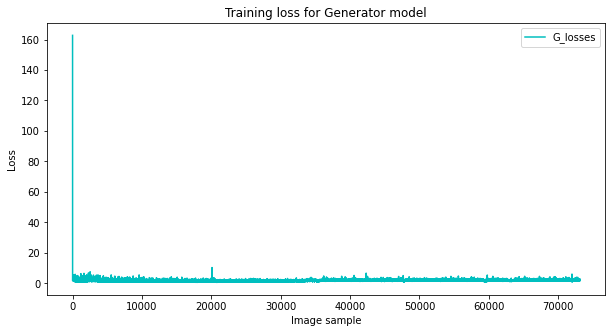

In [9]:
## Plot losses
d_losses = []
g_losses = []
with open('./backup_losses_14_epocs.csv', 'r') as file:
    spanreader = csv.reader(file, delimiter=';')
    for row in spanreader:
        d_losses.append(float(row[0]))
        g_losses.append(float(row[1]))
        
def smooth(scalars, weight=.2):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

plt.figure(figsize=(10, 5))
# line 1 points
# plotting the line 1 points 
# plt.plot(smooth(d_losses), label = "D_losses")
plt.plot(smooth(g_losses), label = "G_losses", color='c')
# plt.plot(smooth(metric_result[2]), label = "BINARY INV")
# plt.plot(smooth(metric_result[3]), label = "TRUNC")
# plt.plot(smooth(metric_result[4]), label = "TOZERO")
# plt.plot(smooth(metric_result[5]), label = "TOZERO INV")
plt.xlabel('Image sample')
plt.ylabel('Loss')
plt.title('Training loss for Generator model')
# show a legend on the plot
plt.legend()
# Display a figure.
fig1 = plt.gcf()
fig1.savefig('g_losses_14_epocs.jpg')
plt.show()

In [7]:
TRAIN_IMAGES = glob('./trainA/*.jpg')
TEST_IMAGES = glob('./predicted_decrapp_v2_800/crappy/*.jpg')

print(len(TRAIN_IMAGES))
print(len(TEST_IMAGES))

def load_images(path):
    img_height = 768
    img_width = 512
    image_list = np.zeros((len(path), img_height, img_width, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(img_height, img_width))
        x = image.img_to_array(img).astype('float32')
        image_list[i] = x
    
    return image_list

80
1000


In [8]:
x_train = load_images(TRAIN_IMAGES)
x_test = load_images(TEST_IMAGES)

In [ ]:
x_train_gan = gan.g_AB.predict(x_train[:5])
x_test_gan = gan.g_AB.predict(x_test[:5])

In [ ]:
np.save('original_x_train_gan', x_train_gan)
np.save('original_x_test_gan', x_test_gan)

In [ ]:
gan.d_A.save('retrained_original_d_A.h5')
gan.d_B.save('retrained_original_d_B.h5')
gan.g_AB.save('retrained_original_g_AB.h5')
gan.g_BA.save('retrained_original_g_BA.h5')

In [ ]:
import pickle

In [9]:
modelin = load_model('backup_g_BA_14_epocs.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

In [23]:
print(len(x_test))

1000


In [14]:
new_img = modelin.predict(x_test[:10])
new_img[1].shape
import timeit
import imageio

def create_chunks(list_name, n):
    for i in range(0, len(list_name), n):
        yield list_name[i:i + n]

image_index = 0
preprocess_time = []
for chunk in create_chunks(x_test, 10):
    tic = timeit.default_timer()
    predictions = modelin.predict(chunk)
    toc = timeit.default_timer()
    preprocess_time.append((toc - tic))
    for image in predictions:
        imageio.imwrite('./predicted_decrapp_v2_800/predicted_cycle_gan/{}.jpg'.format(image_index), image)
#         cv2.imwrite(, image)
#         plt.figure(figsize=(768,512))
#         plt.imshow(image, cmap='gray')
#         plt.axis('off')
#         corrected = plt.gcf()
#         corrected.savefig('./predicted_decrapp_v2_800/predicted_cycle_gan/{}.jpg'.format(image_index))
        image_index += 1

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [13]:
from statistics import mean, median
mean(preprocess_time)

0.0197399178460073

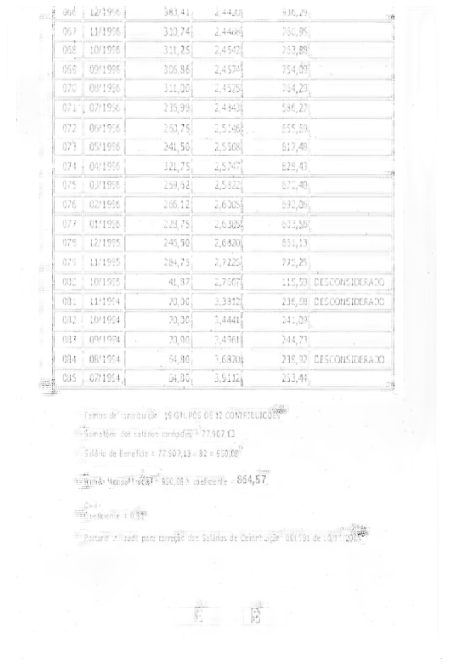

In [17]:
plt.figure(figsize=(16,12))
plt.imshow(new_img[2], cmap='gray')
plt.axis('off')
# corrected = plt.gcf()
# corrected.savefig('1004871_310554941_13_corrected.jpg')
# plt.title('ORIGINAL IMAGE')
plt.show()

In [11]:
import rouge
import csv
import os
import re
import shutil
import collections
from datetime import datetime

class RougeMetric:
    """
    Rouge Metric class to compute both Rouge-N and Rouge-L summarization metrics;

    Parameters
    ----------
    - max_n: int, optional, default to 4
        Defines maximum N value to Rouge-N metric
    - alpha: float, optional, default to 0.5
        # TODO: describe alpha argument
    - weight_factor: float, optional, default to 1.2
        # TODO: describe weight_factor argument
    - batch_size: int, optional, default to 1000
        Defines the size of the batches that the data will be divided by.

    Attributes
    ----------
    - data: array
        Stores the loaded data value containing file reference, original text reference, simple image processing reference, GAN processing reference and Decrappification reference
    - computed_data_size: int
        Stores the count of processed data
    - rouge_instance: Rouge
        Instance of Rouge metric
    - BATCH_SIZE: int, imutable
        Stores the batch size
    """
    data = []
    computed_data_size = 0
    max_n = 1
    rouge_instance = {}
    BATCH_SIZE = 1000

    def __init__(self, max_n=4, alpha=0.5, weight_factor=1.2, batch_size=1000):
        self.rouge_instance = rouge.Rouge(
                metrics=['rouge-n', 'rouge-l'],
                max_n=max_n,
                limit_length=True,
                length_limit=100,
                length_limit_type='words',
                apply_avg=True,
                alpha=alpha,
                weight_factor=weight_factor,
                stemming=True
            )

        self.BATCH_SIZE = batch_size


    def compute_metric_value(self):
        """
        Get stored data and apply both Rouge-N and Rouge-L metrics to it.
        It consider both computed_data_size and data class arguments to compute only remaining data.

        It changes the class data attribute to an array object keys to contain:
        - text: current data reference text or original text
        - rouge_metric: contains the result of Rouge metrics
        """
 
        start = 0
        end = len(self.data)
        if self.computed_data_size % self.BATCH_SIZE == 0:
            start = self.computed_data_size
        slice_obj = slice(start, end)
        for data in self.data[slice_obj]:
            # print('Evaluating data for "{}" file'.format(data['file_reference']))
            data_reference = data['reference']
            for key in ['simple_processor', 'gan_processor', 'decrappification_processor', 'crappy_processor']:
                data[key] = {
                        'text': data[key],
                        'rouge_metric': self.rouge_instance.get_scores(data[key], data_reference)
                    }
            self.computed_data_size += 1


    def store_data(self, file_reference, reference, simple_processor, gan_processor, decrappification_processor, crappy_reference=None):
        """
        Store loaded data as an object containing.

        Parameters
        ----------
        - file_reference: str
            Path to original file
        - reference: str
            Original text of the file_reference
        - simple_processor: str
            Text containing the OCR result of images generated by simple image processor
        - gan_processor: str
            Text containing the OCR result of images generated by GAN model image processor
        - decrappification_processor: str
            Text containing the OCR result of images generated by Decrappification image processor
        - crappy_reference: str, optional
            Text containing the OCR result from crappy image
        """

        data_length = len(self.data)
        if data_length % self.BATCH_SIZE == 0 and data_length > 0:
            self.compute_metric_value()

        ref_dict = {
                'file_reference': file_reference,
                'reference': reference,
                'simple_processor': simple_processor,
                'gan_processor': gan_processor,
                'decrappification_processor': decrappification_processor,
                'crappy_processor': crappy_reference if crappy_reference is not None else ''
            }
        self.data.append(ref_dict)


    def export_data(self, filename, delimiter=';'):
        """
        Export stored data to CSV file. If given filename exists, it will create a backup file.

        Parameters
        ----------
        - filename: str
            Path to destination file
        - delimiter: str, default to ';'
            CSV delimiter

        Returns
        -------
        - result: dict
            The result dict contains 'rows' (int) and 'backup_filename' (str) keys.
            'rows' define the count of written data on file and 'backup_filename' is the backup filename if
            the given filename exists.
        """
        if self.computed_data_size != len(self.data):
            self.compute_metric_value()

        if os.path.exists(filename):
            timestamp_now = datetime.now().timestamp()
            name = filename
            if re.search('\.csv$', filename):
                name = name.replace('.csv', '')

            backup_filename = '{}-{}.csv'.format(name, timestamp_now)
            print('Warn: {} exists. Moving it to {}'.format(filename, backup_filename))
            shutil.move(filename, backup_filename)

        with open(filename, 'w') as csvfile:
            writer = None
            header = ['file_reference']
            header_written = False
            # TODO: minimize method complexity
            for i, data in enumerate(self.data):
                row = {
                        'file_reference': data['file_reference']
                    }
                for index, key in enumerate(data):
                    if re.search('processor', key):
                        processor = key.split('_')[0]
                        metric_value = list(sorted(data[key]['rouge_metric'].items(), key=lambda x: x[0]))
                        for metric_key, value in metric_value:
                            row_key = '{}_{}'.format(processor, metric_key)
                            if i == 0:
                                header.append(row_key)
                            row[row_key] = value
                if i == 0:
                    writer = csv.DictWriter(csvfile, fieldnames=header, delimiter=delimiter)
                    writer.writeheader()
                writer.writerow(row)

In [34]:
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
import timeit

metric = RougeMetric()
preprocess_time = []

def create_chunks(list_name, n):
    for i in range(0, len(list_name), n):
        yield list_name[i:i + n]

index = 0
for p in create_chunks(x_test, 10):
    print(p.shape)
    tic = timeit.default_timer()
    predictions = modelin.predict(p)
    toc = timeit.default_timer()
    preprocess_time.append((toc - tic) / 10)
    
    for item in predictions:
        print(item.shape)
        if index % 100 == 0:
            print('batch: {}'.format(index))
        # get image paths
        original = './predicted_decrapp_v2_800/original/{}.jpg'.format(index)
        crappy = './predicted_decrapp_v2_800/crappy/{}.jpg'.format(index)

        # extract text from images
        original_image = cv2.imread(original)
        print(original_image.shape)
        original_text = pytesseract.image_to_string(original, lang='por+eng')

        crappy_image = cv2.imread(crappy)
        crappy_text = pytesseract.image_to_string(crappy_image, lang='por+eng')

        corrected_text = pytesseract.image_to_string(item, lang='por+eng')

        metric.store_data(p, original_text, corrected_text, '', '', crappy_text)
        index += 1

(10, 768, 512, 1)
(768, 512, 1)
batch: 0
(800, 800, 3)


TypeError: Cannot handle this data type: (1, 1, 1), <f4